In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "Phi2"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
from datasets import load_dataset
#dataset = load_dataset("Phanh2532/GAML-151", download_mode="force_redownload")

train_dataset = load_dataset('json', data_files='151.json', split='train')
eval_dataset = load_dataset('json', data_files='eval.json', split='train')
print(train_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['answer', 'question'],
    num_rows: 149
})


In [6]:
def formatting_func(input):
  text = f"### Question: {input['question']}\n ### Answer: {input['answer']}"
  return text

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "microsoft/phi-2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, low_cpu_mem_usage = True)

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

158


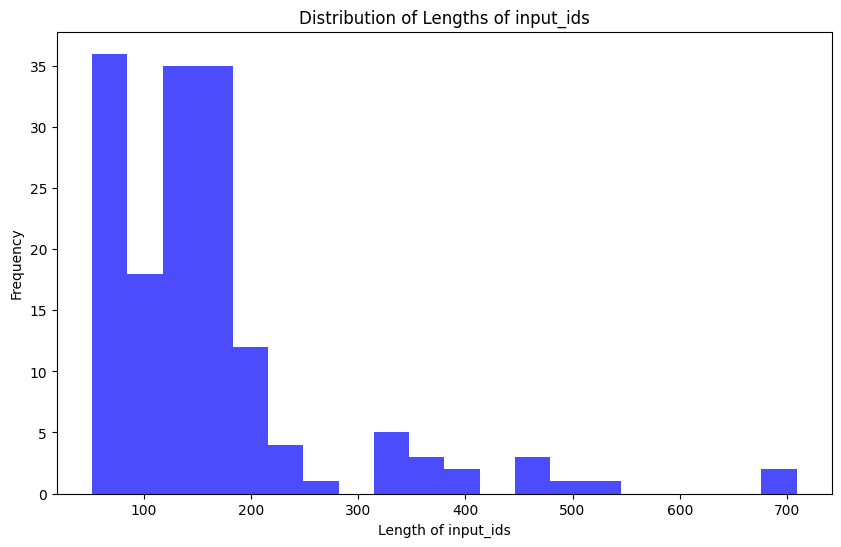

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 750 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

158


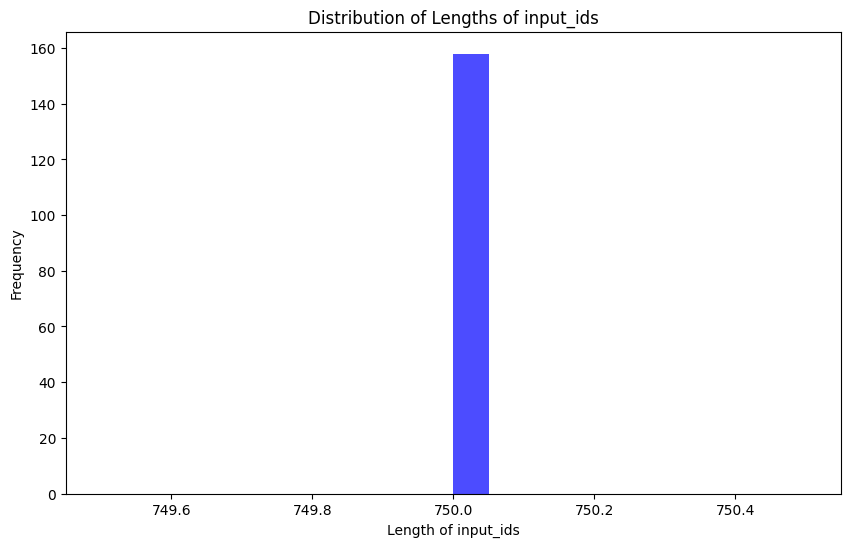

In [13]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [16]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

In [17]:
from peft import LoraConfig, get_peft_model
model.train() # put model back into training model

config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "dense",
        "fc1",
        "fc2",
        "lm_head",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 97812480 || all params: 1619205120 || trainable%: 6.040771412580513


In [18]:
model = accelerator.prepare_model(model)

In [19]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [20]:
import transformers
from datetime import datetime

base_model_name = "phi2"
run_name = base_model_name
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=5.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [21]:
trainer.train()

wandb: Currently logged in as: phuonganhnn25-3 (7bmistral). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.812400,2.114050
100,0.562000,1.929064
150,0.381100,2.065909
200,0.296900,2.202896
250,0.214800,2.339746
300,0.217200,2.286953
350,0.165900,2.396563
400,0.116500,2.496825
450,0.117400,2.443969
500,0.116800,2.510790


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=500, training_loss=0.3502438340187073, metrics={'train_runtime': 4376.3259, 'train_samples_per_second': 0.229, 'train_steps_per_second': 0.114, 'total_flos': 1.228475598336e+16, 'train_loss': 0.3502438340187073, 'epoch': 6.67})

In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "microsoft/phi-2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, low_cpu_mem_usage = True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/phi2/checkpoint-450")

In [29]:
eval_prompt = "Create a GAML model name air_pollution to simulate water pollution"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.11)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|endoftext|>Create a GAML model name air_pollution to simulate water pollution by factories in a city. Include parameters like factory_density, pollution_rate, and neighbors_at_max 60. Additionally, implement a species named "Factory" with attributes such as factoryID, pollutionLevel, and location. Factory species should be created based on factory_density and pollution_rate conditions.
Answer: model air_pollution {
      float factory_density <- 0.05;
      float pollution_rate <- 0.03;
      int neighbors_at_max <- 60;

      species factory {
          int factoryID;
          float pollutionLevel;
          location myLocation <- one_of(location);
          
          init {
              factoryID <- rnd(1, 1000);
              pollutionLevel <- rnd(0.01, 1.0);
          }

          aspect base {
              draw rectagle(myLocation.width, myLocation.height) color: #gray;
              pollutionLevel <- pollutionLevel + pollutionRate;
          }
      }
}

experiment air_poll